## SMM768 Applied Deep Learning Group Assignment - Group 9

1. Briefly discuss why it is more difficult to find a good classifier on such a dataset than on one where, for example, 5,000 claims are fraudulent, and 5,000 are not. In particular, consider what happens when undetected fraudulent claims are very costly to the insurance company.

Our dataset is an imbalanced dataset where the number of observations in the dataset for each class is uneven and the class distribution is severely skewed. Most of the machine learning algorithims for classification were built around the assumption of an equal class distribution in order to have an accurate prediction for both classes. A model built from an imbalanced training data will classify all test instances to the majority class and results in a classifier where the predictive performance is inaccurate for the minority class. In the context of insurance company, if the majority class is "non-fraudulent" in the data, the classifier would predict every claims to be non-fraudulent and never detect a fraud. This can increase the loss of the company continuously and drive insurance prices more expensive for every policy holder. 

2.  Load the dataset "Insurance_claims.csv" and clean it as appropriate for use with machine learning algorithms. A description of the features can be found at the end of this document.

In [262]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [263]:
# load the dataset
claims = pd.read_csv('Insurance_claims.csv')

In [264]:
# drop unnecessary columns
claims = claims.drop(['PolicyholderNumber', 'FirstPartyVehicleNumber', 'ThirdPartyVehicleNumber', 'InsurerNotes'], axis = 1)

In [265]:
# check NA values
claims.isna().any()

PolicyholderOccupation              True
LossDate                           False
FirstPolicySubscriptionDate        False
ClaimCause                          True
ClaimInvolvedCovers                 True
DamageImportance                    True
FirstPartyVehicleType               True
ConnectionBetweenParties            True
PolicyWasSubscribedOnInternet      False
NumberOfPoliciesOfPolicyholder     False
FpVehicleAgeMonths                  True
EasinessToStage                    False
ClaimWihoutIdentifiedThirdParty    False
ClaimAmount                        False
LossHour                            True
PolicyHolderAge                     True
NumberOfBodilyInjuries             False
FirstPartyLiability                False
Fraud                              False
LossAndHolderPostCodeSame          False
dtype: bool

In [266]:
# fillna for the following categorical variables:
cat_list = ["PolicyholderOccupation", "ClaimCause", "ClaimInvolvedCovers", 
    "DamageImportance", "FirstPartyVehicleType", "ConnectionBetweenParties"]

for cat in cat_list:
    claims[cat] = claims[cat].fillna("Not Given")
    claims[cat] = pd.Categorical(claims[cat])

# create a reference table to each variable
a = claims.PolicyholderOccupation.value_counts().index.tolist()
b = claims.PolicyholderOccupation.cat.codes.value_counts().index.tolist()
PolicyholderOccupation_codelist = pd.DataFrame(a,b)

a = claims.FirstPartyVehicleType.value_counts().index.tolist()
b = claims.FirstPartyVehicleType.cat.codes.value_counts().index.tolist()
FirstPartyVehicleType_codelist = pd.DataFrame(a,b)

a = claims.ClaimCause.value_counts().index.tolist()
b = claims.ClaimCause.cat.codes.value_counts().index.tolist()
ClaimCause_codelist = pd.DataFrame(a,b)

a = claims.ClaimInvolvedCovers.value_counts().index.tolist()
b = claims.ClaimInvolvedCovers.cat.codes.value_counts().index.tolist()
ClaimInvolvedCovers_codelist = pd.DataFrame(a,b)

a = claims.DamageImportance.value_counts().index.tolist()
b = claims.DamageImportance.cat.codes.value_counts().index.tolist()
DamageImportance_codelist = pd.DataFrame(a,b)

a = claims.ConnectionBetweenParties.value_counts().index.tolist()
b = claims.ConnectionBetweenParties.cat.codes.value_counts().index.tolist()
ConnectionBetweenParties_codelist = pd.DataFrame(a,b)

# categorise 'PolicyHolderAge'
claims.loc[(claims['PolicyHolderAge'].isna()), 'PolicyHolderAge'] = 100
claims['PolicyHolderAge'] = claims['PolicyHolderAge'].astype(int)
claims['PolicyAge_Cat'] = 0
claims.loc[(claims["PolicyHolderAge"] <= 20), 'PolicyAge_Cat'] = 1
claims.loc[(claims["PolicyHolderAge"] > 20) & (claims["PolicyHolderAge"] <= 30) , 'PolicyAge_Cat'] = 2
claims.loc[(claims["PolicyHolderAge"] > 30) & (claims["PolicyHolderAge"] <= 40) , 'PolicyAge_Cat'] = 3
claims.loc[(claims["PolicyHolderAge"] > 40) & (claims["PolicyHolderAge"] <= 50) , 'PolicyAge_Cat'] = 4
claims.loc[(claims["PolicyHolderAge"] > 50) & (claims["PolicyHolderAge"] <= 60) , 'PolicyAge_Cat'] = 5
claims.loc[(claims["PolicyHolderAge"] > 60) & (claims["PolicyHolderAge"] <= 70) , 'PolicyAge_Cat'] = 6
claims.loc[(claims["PolicyHolderAge"] > 70) & (claims["PolicyHolderAge"] <= 80) , 'PolicyAge_Cat'] = 7
claims.loc[(claims["PolicyHolderAge"] > 80) , 'PolicyAge_Cat'] = 8
claims.loc[(claims["PolicyHolderAge"] == 100) , 'PolicyAge_Cat'] = 9

# replace NA in loss hour to 25
claims["LossHour"] = claims["LossHour"].fillna(25)

# one-hot encoding for categorical data
cat_col = ["PolicyholderOccupation", "ClaimCause", "ClaimInvolvedCovers", "DamageImportance",
     "FirstPartyVehicleType", "ConnectionBetweenParties", "LossHour", "PolicyAge_Cat",
     "EasinessToStage", "PolicyHolderAge"]
claims = pd.get_dummies(claims, drop_first = True, columns = cat_col)

In [267]:
# split train/test set before preprocessing
claims_x = claims.drop(["Fraud"], axis = 1)
claims_y = claims['Fraud']
X_train, X_other, y_train, y_other = train_test_split(claims_x, claims_y, test_size=0.7, random_state = 657)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(3459, 226)
(4036, 226)
(4035, 226)


In [268]:
# define function to perform data processing
def preprocess(x):
    # replace NA in column 'FpVehicleAgeMonths' with median
    x['FpVehicleAgeMonths'] = x['FpVehicleAgeMonths'].replace(np.nan, x['FpVehicleAgeMonths'].median())
    
    # create a new variable to measure the days between first policy subscription and loss date
    x['LossDate'] = pd.to_datetime(x['LossDate'])
    x['FirstPolicySubscriptionDate'] = pd.to_datetime(x['FirstPolicySubscriptionDate'])
    x['LossDaysAfterFirstSubscription'] = x["LossDate"]-x['FirstPolicySubscriptionDate']
    x['LossDaysAfterFirstSubscription'] = x['LossDaysAfterFirstSubscription'].apply(lambda x: x.days)
    # drop unnecessary columns
    x = x.drop(['LossDate', 'FirstPolicySubscriptionDate'], axis = 1)

    # scale the data
    fpvehicleagemonths_scale=(x.FpVehicleAgeMonths-x.FpVehicleAgeMonths.min())/(x.FpVehicleAgeMonths.max()-x.FpVehicleAgeMonths.min())
    ClaimAmount_scale=(x.ClaimAmount-x.ClaimAmount.min())/(x.ClaimAmount.max()-x.ClaimAmount.min())
    LossDaysAfterFirstSubscription_scale=(x.LossDaysAfterFirstSubscription-x.LossDaysAfterFirstSubscription.min())/(x.LossDaysAfterFirstSubscription.max()-x.LossDaysAfterFirstSubscription.min())
    NumberOfPoliciesOfPolicyholder_scale=(x.NumberOfPoliciesOfPolicyholder-x.NumberOfPoliciesOfPolicyholder.min())/(x.NumberOfPoliciesOfPolicyholder.max()-x.NumberOfPoliciesOfPolicyholder.min())
    x.FpVehicleAgeMonths = fpvehicleagemonths_scale
    x.ClaimAmount = ClaimAmount_scale
    x.LossDaysAfterFirstSubscription = LossDaysAfterFirstSubscription_scale
    x.NumberOfPoliciesOfPolicyholder = NumberOfPoliciesOfPolicyholder_scale

    return x

In [269]:
# run the data processing function to training validation and testing sets
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)
print(X_train.isna().any())
print(X_valid.isna().any())
print(X_test.isna().any())

PolicyWasSubscribedOnInternet      False
NumberOfPoliciesOfPolicyholder     False
FpVehicleAgeMonths                 False
ClaimWihoutIdentifiedThirdParty    False
ClaimAmount                        False
                                   ...  
PolicyHolderAge_88                 False
PolicyHolderAge_89                 False
PolicyHolderAge_90                 False
PolicyHolderAge_100                False
LossDaysAfterFirstSubscription     False
Length: 225, dtype: bool
PolicyWasSubscribedOnInternet      False
NumberOfPoliciesOfPolicyholder     False
FpVehicleAgeMonths                 False
ClaimWihoutIdentifiedThirdParty    False
ClaimAmount                        False
                                   ...  
PolicyHolderAge_88                 False
PolicyHolderAge_89                 False
PolicyHolderAge_90                 False
PolicyHolderAge_100                False
LossDaysAfterFirstSubscription     False
Length: 225, dtype: bool
PolicyWasSubscribedOnInternet      False
NumberO

3. Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, then evaluate it on the test set. In particular, record both the accuracy and AUC. Briefly discuss what issues you observe based on the metrics.

In [270]:
#import libraries
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

In [271]:
#clear out TensorFlow's cache
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [272]:
#train the TensorFlow model
def train_model(hp):    
    num_units = hp.Int('num_units', min_value = 3, max_value=20) 
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid")
])    
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
    model.compile(optimizer=optimizer,
                loss='mean_squared_error')
    
    return model

In [273]:
rm -rf ./logs2/group_assignment

In [274]:
#use Hyperband to tune the model
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='group_assignment')
tuner.search(X_train, y_train, validation_data=(X_valid,y_valid))

Trial 30 Complete [00h 00m 05s]
val_loss: 0.010158573277294636

Best val_loss So Far: 0.010010549798607826
Total elapsed time: 00h 01m 29s
INFO:tensorflow:Oracle triggered exit


In [275]:
#get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best dropout rate: " + str(best_hps['dropout_rate']))
print("Best number of hidden units: " + str(best_hps['num_units']))

Best learning rate: 0.05050850713898753
Best optimizer: sgd
Best dropout rate: 0.2907472995869832
Best number of hidden units: 17


In [276]:
#build the model that uses the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

In [277]:
best_model.compile(loss="mean_squared_error",
              metrics = ["acc",tf.keras.metrics.AUC()])

In [278]:
#implement early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [279]:
best_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_valid,y_valid),
               callbacks=[early_stopping_cb])
print((best_model.evaluate(X_test, y_test)))

Epoch 1/30
109/109 [==============================] - 2s 7ms/step - loss: 0.0680 - acc: 0.9624 - auc: 0.5508 - val_loss: 0.0104 - val_acc: 0.9898 - val_auc: 0.5395
Epoch 2/30
109/109 [==============================] - 0s 4ms/step - loss: 0.0107 - acc: 0.9899 - auc: 0.5048 - val_loss: 0.0101 - val_acc: 0.9898 - val_auc: 0.5028
Epoch 3/30
109/109 [==============================] - 0s 4ms/step - loss: 0.0101 - acc: 0.9899 - auc: 0.4892 - val_loss: 0.0102 - val_acc: 0.9898 - val_auc: 0.4999
Epoch 4/30
109/109 [==============================] - 0s 4ms/step - loss: 0.0101 - acc: 0.9899 - auc: 0.5069 - val_loss: 0.0102 - val_acc: 0.9898 - val_auc: 0.5000
Epoch 5/30
109/109 [==============================] - 0s 4ms/step - loss: 0.0101 - acc: 0.9899 - auc: 0.5458 - val_loss: 0.0102 - val_acc: 0.9898 - val_auc: 0.5000
Epoch 6/30
109/109 [==============================] - 0s 4ms/step - loss: 0.0101 - acc: 0.9899 - auc: 0.5253 - val_loss: 0.0102 - val_acc: 0.9898 - val_auc: 0.5000
Epoch 7/30
109/1

In [280]:
#confusion matrix
y_pred = best_model.predict(X_test)
print(tf.math.confusion_matrix(y_test, y_pred))

tf.Tensor(
[[3996    0]
 [  39    0]], shape=(2, 2), dtype=int32)


Text(0,0.5,'Count')

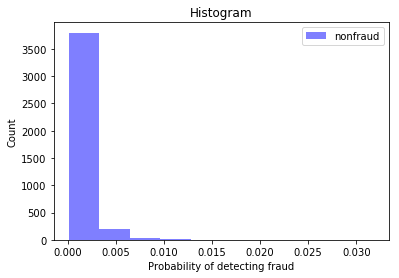

In [281]:
# Histogram of detecting fraudulent claims 
plt.hist(y_pred,color='b', label='nonfraud',alpha=0.5)
plt.legend()
plt.title('Histogram')
plt.xlabel('Probability of detecting fraud')
plt.ylabel('Count')

The testing set gave a high accuracy score of 0.99 but a low AUC score of 0.5. As shown in the histogram, the probabilities of detecting any fraud is zero for the whole dataset. This could be due to fraud cases making up of just 1% of the dataset, creating a severe class-imbalanced distribution. Hence, the model had over-predicted the majority class, which is the non-fraud cases.

In [282]:
#save it as h5 file
best_model.save("best_model.h5")

### first approach: SMOTE

4. The file "SMOTE.ipynb" explains the process in detail and shows how to change the dataset with an example. You can copy and adjust the code to make it work within your analysis. You can adjust the "sampling_strategy" parameters as you see fit, particularly if you want to fine-tune your model in part 5.

In [21]:
#import libraries
import imblearn
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [232]:
# Obatin column index for categorical features
over = SMOTE(random_state=123, sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.3, random_state = 241)
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_synth, y_synth = pipeline.fit_resample(X_train, y_train)

In [219]:
#look at the shape of the SMOTE created data
print(y_train.shape)
print(np.sum(y_train))

print(y_synth.shape)
print(np.sum(y_synth))

(3459,)
35
(1482,)
342


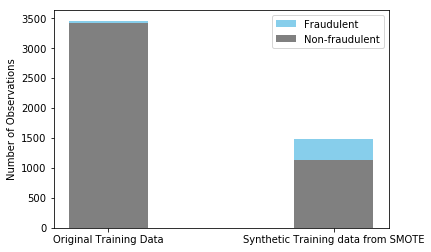

In [233]:
#bar chart to show how we resmaple the data
train_nf = y_train.value_counts()[0]
synth_nf = y_synth.value_counts()[0]
train_f = y_train.value_counts()[1]
synth_f = y_synth.value_counts()[1]

labels = ['Original Training Data', 'Synthetic Training data from SMOTE']
nonfraud = [train_nf, synth_nf]
fraud = [train_f, synth_f]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, fraud, width, label='Fraudulent', bottom=nonfraud, color='skyblue')
ax.bar(labels, nonfraud, width, label='Non-fraudulent', color = 'grey')

ax.set_ylabel('Number of Observations')
ax.legend()

plt.show()

5. Create a new (deep) neural network and train it on your enhanced dataset. Use training and validation sets derived from the enhanced dataset to find a model with high accuracy. Evaluate your final model on a test set consisting only of original data. Again, record the accuracy and AUC. Briefly discuss the changes you would expect in the metrics and the actual changes you observe. Would you say that you are now doing better at identifying fraudulent claims?

In [234]:
rm -rf ./logs2/group_assignment_SMOTE

In [235]:
#build the model for SMOTE dataset
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs2',
                     project_name='group_assignment_SMOTE')
tuner.search(X_synth, y_synth, validation_data=(X_valid,y_valid))

Trial 30 Complete [00h 00m 05s]
val_loss: 0.010534405708312988

Best val_loss So Far: 0.010156056843698025
Total elapsed time: 00h 01m 14s
INFO:tensorflow:Oracle triggered exit


In [236]:
#get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best dropout rate: " + str(best_hps['dropout_rate']))
print("Best number of hidden units: " + str(best_hps['num_units']))

Best learning rate: 0.42905236012481845
Best optimizer: adam
Best dropout rate: 0.11543704176746217
Best number of hidden units: 10


In [237]:
best_model_SMOTE = tuner.hypermodel.build(best_hps)

In [238]:
best_model_SMOTE.compile(loss="mean_squared_error",
              metrics = ["acc",tf.keras.metrics.AUC()])

In [239]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [240]:
#fit the SMOTE dataset to the model
log = best_model_SMOTE.fit(X_synth, y_synth,
               epochs=30,
               validation_data=(X_valid,y_valid),
               callbacks=[early_stopping_cb])
Evaluate = best_model_SMOTE.evaluate(X_test, y_test)

Epoch 1/30
47/47 [==============================] - 1s 11ms/step - loss: 0.2370 - acc: 0.6451 - auc: 0.5592 - val_loss: 0.1794 - val_acc: 0.9898 - val_auc: 0.5742
Epoch 2/30
47/47 [==============================] - 0s 7ms/step - loss: 0.1830 - acc: 0.7692 - auc: 0.7326 - val_loss: 0.0914 - val_acc: 0.9898 - val_auc: 0.5756
Epoch 3/30
47/47 [==============================] - 0s 7ms/step - loss: 0.1522 - acc: 0.7692 - auc: 0.8668 - val_loss: 0.0573 - val_acc: 0.9898 - val_auc: 0.6411
Epoch 4/30
47/47 [==============================] - 0s 6ms/step - loss: 0.1327 - acc: 0.7692 - auc: 0.9390 - val_loss: 0.0462 - val_acc: 0.9898 - val_auc: 0.7023
Epoch 5/30
47/47 [==============================] - 0s 6ms/step - loss: 0.1156 - acc: 0.7969 - auc: 0.9496 - val_loss: 0.0402 - val_acc: 0.9889 - val_auc: 0.7362
Epoch 6/30
47/47 [==============================] - 0s 8ms/step - loss: 0.0962 - acc: 0.8603 - auc: 0.9626 - val_loss: 0.0357 - val_acc: 0.9837 - val_auc: 0.7535
Epoch 7/30
47/47 [=========

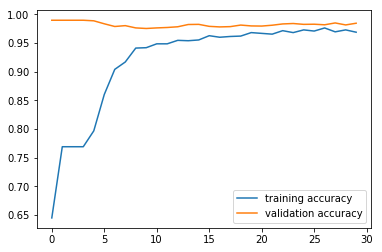

In [241]:
plt.plot(log.history['acc'],label = "training accuracy")
plt.plot(log.history['val_acc'], label = "validation accuracy")
plt.legend()
plt.show()

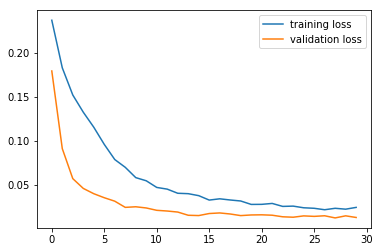

In [242]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [243]:
#accuracy and AUC score
print("Accuracy score for SMOTE model is:" , Evaluate[1])
print("AUC score for SMOTE model is:" , Evaluate[2])                             

Accuracy score for SMOTE model is: 0.9853779673576355
AUC score for SMOTE model is: 0.7216677069664001


In [244]:
#confusion matrix
y_pred_SMOTE = best_model_SMOTE.predict(X_test)
y_prob_SMOTE = np.where(y_pred_SMOTE < 0.5, 0, 1)
print(tf.math.confusion_matrix(y_test, y_prob_SMOTE))

tf.Tensor(
[[3968   27]
 [  32    8]], shape=(2, 2), dtype=int32)


In [245]:
#save it as h5 file
best_model_SMOTE.save("best_model_SMOTE.h5")

Since SMOTE method oversampled the minority class (fraud class) and balanced out the observations of the two classes for the training data, the model built from this method should successfully predict fraud in the testing data, instead of predicting every test instances to be non-fraudulent. This increases the true positive rate as well as decreases the true negative rate. Therefore, the expected changes in metrices for using SMOTE is that AUC will increase and the accuracy score will decrease from the previous model. 

The actual outcome was that AUC had increased 22% and accuracy had decreased to 98.54%, suggesting that the model had correctly dectected fraud cases within the dataset. Hence, this model is now better at identifying fraudulent claims. 

### second approach: autoencoder

6. Using the original data, create a training and set that contains only non-fraudulent claims, as well as validation and test sets that contain non-fraudulent and fraudulent claims. Make sure to spread fraudulent claims evenly across validation and test sets.

In [37]:
#import library
from sklearn import preprocessing 

In [38]:
#divide dataset into fraud and nonfraud
claims_nonfraud = claims[claims['Fraud']==0]
claims_fraud = claims[claims['Fraud']==1]

In [39]:
#preprocessing data and scaling data into useful format for autoencoder
claims_nonfraud_x = claims_nonfraud.drop(["Fraud"], axis = 1)
claims_nonfraud_y = claims_nonfraud['Fraud']
X_train_nonfraud, X_other_nonfraud, y_train_nonfraud, y_other_nonfraud = train_test_split(claims_nonfraud_x, claims_nonfraud_y, test_size=0.7, random_state = 657)
X_test_nonfraud, X_valid_nonfraud, y_test_nonfraud, y_valid_nonfraud = train_test_split(X_other_nonfraud, y_other_nonfraud, train_size = 0.5, random_state=391)
X_train_nonfraud = preprocess(X_train_nonfraud)
X_test_nonfraud = preprocess(X_test_nonfraud)
X_valid_nonfraud = preprocess(X_valid_nonfraud)
X_train_nonfraud = preprocessing.MinMaxScaler().fit_transform(X_train_nonfraud.values)
X_test_nonfraud = preprocessing.MinMaxScaler().fit_transform(X_test_nonfraud.values)
X_valid_nonfraud = preprocessing.MinMaxScaler().fit_transform(X_valid_nonfraud.values)


In [40]:
#preprocessing data and scaling data into useful format for autoencoder
claims_fraud_x = claims_fraud.drop(["Fraud"], axis = 1)
claims_fraud_y = claims_fraud['Fraud']
X_train_fraud, X_other_fraud, y_train_fraud, y_other_fraud = train_test_split(claims_fraud_x, claims_fraud_y, test_size=0.7, random_state = 657)
X_test_fraud, X_valid_fraud, y_test_fraud, y_valid_fraud = train_test_split(X_other_fraud, y_other_fraud, train_size = 0.5, random_state=391)
X_train_fraud = preprocess(X_train_fraud)
X_test_fraud = preprocess(X_test_fraud)
X_valid_fraud = preprocess(X_valid_fraud)
X_train_fraud = preprocessing.MinMaxScaler().fit_transform(X_train_fraud.values)
X_test_fraud = preprocessing.MinMaxScaler().fit_transform(X_test_fraud.values)
X_valid_fraud = preprocessing.MinMaxScaler().fit_transform(X_valid_fraud.values)

In [41]:
#concat the dataset to makesure in the test dataset the fraud cases are evenly allocated
X_test = np.concatenate([X_test_nonfraud, X_test_fraud])
y_test = np.concatenate([y_test_nonfraud,y_test_fraud])
X_valid = np.concatenate([X_valid_nonfraud, X_valid_fraud])
y_valid = np.concatenate([y_valid_nonfraud, y_valid_fraud])

7. Using TensorFlow, create an autoencoder, ensuring that the middle hidden layer has fewer neurons than your input has features. Use training and validation sets to find a model that represents its input data well. In particular, you will want to predict your validation set observations. For each observation, you can measure the difference between the original observations and the predicted one, using, for example, the mean squared error of all features of the observation. Plot the errors for all your validation set observations in a histogram - in a good model, this error should be much higher for fraudulent claims than non-fraudulent ones.

In [42]:
#clean the session      
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [43]:
def train_autoencoder(hp):    
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    
    encoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(225, activation="relu", input_shape=X_train_nonfraud.shape[1:],
        activity_regularizer=tf.keras.regularizers.L1(0.001)),
        tf.keras.layers.Dense(14, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(6, activation="relu"),]) 

    decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(14, activation="relu"),
    tf.keras.layers.Dense(225, activation="sigmoid")])
    
    autoencoder = tf.keras.Sequential([encoder,decoder])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            
    autoencoder.compile(optimizer=optimizer,
                loss='mean_squared_error')
    
    return autoencoder

In [44]:
#build the model for autoencoder
tuner = kt.Hyperband(train_autoencoder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs4',s
                     project_name='group_assignment_autoencoder')
tuner.search(X_train_nonfraud, X_train_nonfraud, validation_data=(X_valid,X_valid))

Trial 30 Complete [00h 00m 07s]
val_loss: 0.03673529624938965

Best val_loss So Far: 0.020960940048098564
Total elapsed time: 00h 01m 40s
INFO:tensorflow:Oracle triggered exit


In [45]:
#get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))

Best learning rate: 0.0033497029949067455
Best optimizer: adam


In [46]:
best_model_autoencoder = tuner.hypermodel.build(best_hps)

In [47]:
#get the information of autoencoder
best_model_autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 6)                 54230     
                                                                 
 sequential_4 (Sequential)   (None, 225)               3641      
                                                                 
Total params: 57,871
Trainable params: 57,871
Non-trainable params: 0
_________________________________________________________________


In [48]:
best_model_autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [49]:
#fit model and validate with nonfraud dataset
log = best_model_autoencoder.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid, X_valid))

Epoch 1/30
107/107 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.0000e+00 - val_loss: 0.0344 - val_accuracy: 0.0000e+00
Epoch 2/30
107/107 [==============================] - 0s 4ms/step - loss: 0.0291 - accuracy: 0.0000e+00 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 3/30
107/107 [==============================] - 1s 5ms/step - loss: 0.0266 - accuracy: 0.0000e+00 - val_loss: 0.0262 - val_accuracy: 0.0000e+00
Epoch 4/30
107/107 [==============================] - 1s 5ms/step - loss: 0.0258 - accuracy: 0.0000e+00 - val_loss: 0.0251 - val_accuracy: 0.0000e+00
Epoch 5/30
107/107 [==============================] - 1s 5ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - val_loss: 0.0240 - val_accuracy: 0.0000e+00
Epoch 6/30
107/107 [==============================] - 0s 5ms/step - loss: 0.0237 - accuracy: 0.0000e+00 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 7/30
107/107 [==============================] - 1s 6ms/step - loss: 0.0230 - accuracy: 0.0000e

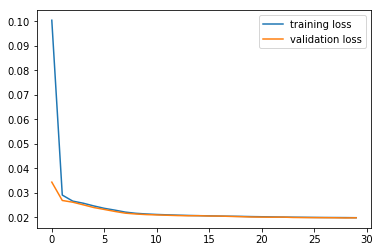

In [50]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [51]:
#fit model and validate with nonfraud dataset
log1 = best_model_autoencoder.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=20,
                validation_data=(X_valid_nonfraud, X_valid_nonfraud))

Epoch 1/20
107/107 [==============================] - 1s 5ms/step - loss: 0.0199 - accuracy: 0.5397 - val_loss: 0.0198 - val_accuracy: 0.5498
Epoch 2/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.5409 - val_loss: 0.0197 - val_accuracy: 0.5408
Epoch 3/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.5426 - val_loss: 0.0197 - val_accuracy: 0.5380
Epoch 4/20
107/107 [==============================] - 0s 5ms/step - loss: 0.0198 - accuracy: 0.5423 - val_loss: 0.0197 - val_accuracy: 0.5308
Epoch 5/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.5459 - val_loss: 0.0197 - val_accuracy: 0.5378
Epoch 6/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.5467 - val_loss: 0.0196 - val_accuracy: 0.5526
Epoch 7/20
107/107 [==============================] - 0s 4ms/step - loss: 0.0197 - accuracy: 0.5511 - val_loss: 0.0197 - val_accuracy: 0.5573
Epoch 

In [52]:
#clean the session
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [53]:
#fit model and validate with fraud dataset
log2 = best_model_autoencoder.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=20,
                validation_data=(X_valid_fraud, X_valid_fraud))

Epoch 1/20
107/107 [==============================] - 1s 3ms/step - loss: 0.0192 - accuracy: 0.5286 - val_loss: 0.0271 - val_accuracy: 0.3415
Epoch 2/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.5307 - val_loss: 0.0270 - val_accuracy: 0.3415
Epoch 3/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.5251 - val_loss: 0.0270 - val_accuracy: 0.3415
Epoch 4/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.5365 - val_loss: 0.0268 - val_accuracy: 0.3415
Epoch 5/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.5350 - val_loss: 0.0271 - val_accuracy: 0.3415
Epoch 6/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.5307 - val_loss: 0.0270 - val_accuracy: 0.3415
Epoch 7/20
107/107 [==============================] - 0s 3ms/step - loss: 0.0191 - accuracy: 0.5350 - val_loss: 0.0270 - val_accuracy: 0.3415
Epoch 

In [54]:
#save the model
best_model_autoencoder.save("autoencoder.h5")

Text(0,0.5,'Count')

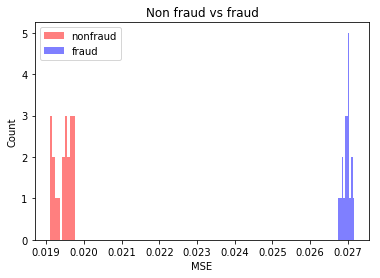

In [55]:
#plot the MSE value histogram of non fraud data and fraud data
plt.hist(log1.history['val_loss'],color='r', label='nonfraud',alpha=0.5)
plt.hist(log2.history['val_loss'], color='b', label='fraud',alpha=0.5)
plt.legend()
plt.title('Non fraud vs fraud')
plt.xlabel('MSE')
plt.ylabel('Count')

8. Use your trained autoencoder to predict the test set and define the corresponding losses. Create a histogram of your test set claims, clearly marking fraudulent and non- fraudulent claims. Discuss how you could use this to decide whether a transaction is fraudulent or not. Can you also derive an AUC in this approach - if yes, how does it perform compared to the previous approaches?

In [56]:
#predict the output and calculate the MSE between original data and predicted data
x_predict = best_model_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - x_predict, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df

,Reconstruction_error,True_class
0,0.019166,0
1,0.015999,0
2,0.016768,0
3,0.014107,0
4,0.026222,0
...,...,...
4030,0.025175,1
4031,0.043128,1
4032,0.031757,1
4033,0.014819,1


/Users/wengmanchiang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


([array([ 0.,  0.,  6., 15.,  5.,  7.,  6.,  1.,  0.,  0.]),
  array([439., 783., 966., 941., 483., 242.,  93.,  32.,   9.,   7.])],
 array([0.00502726, 0.00983247, 0.01463769, 0.0194429 , 0.02424812,
        0.02905333, 0.03385855, 0.03866376, 0.04346898, 0.04827419,
        0.05307941]),
 <a list of 2 Lists of Patches objects>)

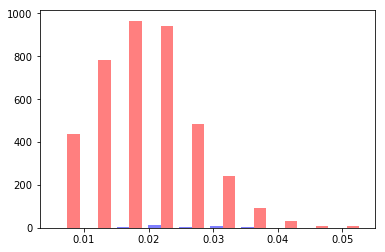

In [57]:
#plot the MSE distribution for nonfraud and fraud data
error_df_fraud = error_df[error_df['True_class']==1]
error_df_nonfraud = error_df[error_df['True_class']==0]
plt.hist([error_df_fraud['Reconstruction_error'], error_df_nonfraud['Reconstruction_error']], color=['b','r'], alpha=0.5)

In [58]:
#import libraries
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, roc_curve

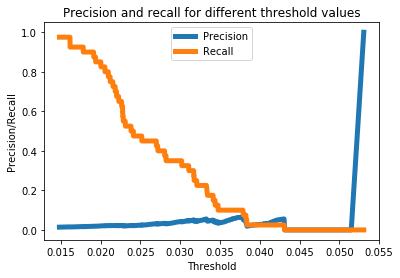

In [59]:
#get the threshold based on precision and recall
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

/Users/wengmanchiang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wengmanchiang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/wengmanchiang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


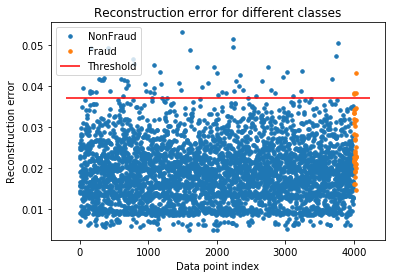

In [60]:
#visualise the classification
error_df_test = error_df.reset_index()
threshold_fixed = 0.037
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "NonFraud")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

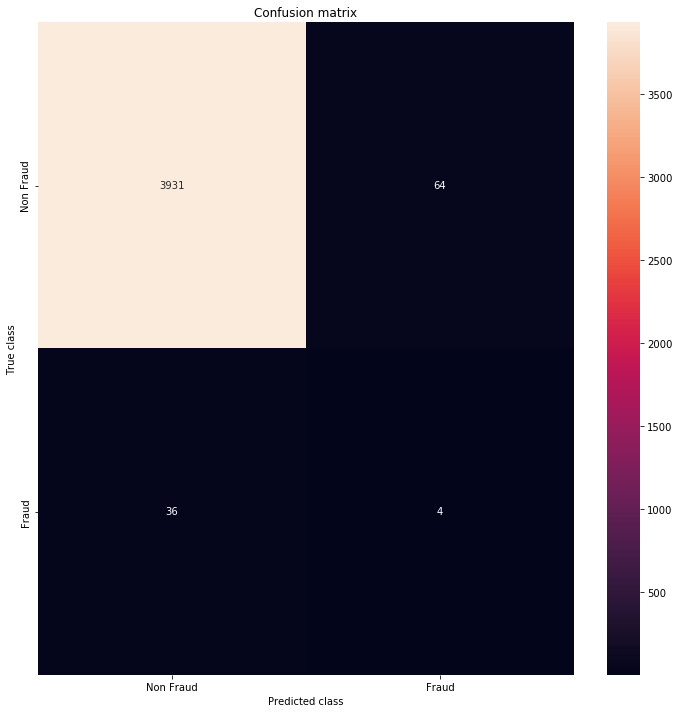

In [61]:
#draw the confusion matrix
LABELS = ["Non Fraud","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

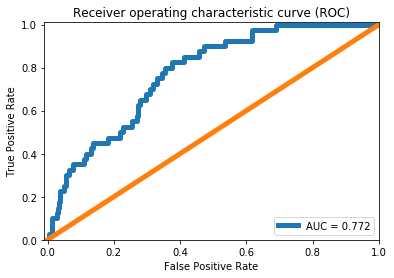

In [62]:
#draw the roc_auc curve and get the auc value
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### -How to decide whether a transaction is fraudulent or not:
The decision is made by the MSE value calculated by original data and predicted data. From the prediction of the autoencoder, we get a new 225 variables. Since the principle of autoencoder is to rebuild the features, and we only train non-fraud data with the model, the MSE of fraud data will be relatively higher than the non-fraud data (pattern difference). Hence, clients with higher MSE will be considered as fraud. 

After obtaining the MSE value, we calculated the threshold from precision and recall to decide above a certain level of MSE will be considered as fraud. The imbalanced data will influence a lot on the accuracy, hence we need to get the balance of precision and recall to make sure retrieved data are relevant but also relevant data will be retrieved.

In our case, we pick 0.037 as the threshold. Hence, when the MSE is higher than 0.037, the customer will be classified as fraud.
#### - How is the AUC performance compared to previous approaches:
The AUC we gained for the model is 0.772, higher than the former approaches (SMOTE and normal splitting), which shows the autoencoder model has a better ability to recognise differences between patterns.

9. As you know, it is difficult to understand precisely why a neural network makes a
specific prediction. Discuss why this might be problematic when the neural network prediction leads to a fraud investigation by the insurance company. What alternatives can you envision that make use of the techniques we have applied and allow for more interpretability and transparency?

A neural network model consists of many layers, making it challenging to recognise which variables determine the prediction. This means that there is a possibility that critical variables may be excluded from the data used for training, leading to unreliable predictions. Insurance companies may find it hard to interpret which factors lead to a predicted fraud by the model. Additionally, it may be difficult to identify issues with the model if the model performance deteriorates even with the same input data. This can result in increased investigation costs and delayed claims processing time. 

The limited visibility of how the model provides a conclusion also suggests a little understanding of biases in the training dataset. It may cause consumers to be subjected to these biases. Hence, organisations may find it more challenging to identify any biases present and eliminate them. Additionally, this may lead to consumers being subjected to these biases, damaging the company's reputation. 

In order to continuously improve the model, the model could be compared using different methods (e.g. Multi-layer Perceptron, Decision Tree). Also, the performance of models across a diverse range of people could be regularly evaluated to identify if any bias arises.

10. Use your synthetically extended dataset and train a simple model, such as logistic
regression or a decision tree that allows you to interpret why fraud is suspected. Keep track of the accuracy and AUC on a test set made from original data only. How does your model perform compared to the previous models you have developed? Does your model allow you to answer a customer who asks, "why am I being investigated"?

In [249]:
#import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [250]:
#divide data into x and y
claims_x = claims.drop(["Fraud"], axis = 1)
claims_y = claims['Fraud']

In [251]:
#split the data and preprocess the data
X_train, X_other, y_train, y_other = train_test_split(claims_x, claims_y, test_size=0.7, random_state = 657)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [252]:
#train the decision tree by synthetic data
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 8)
classifier_DT.fit(X_synth, y_synth)

DecisionTreeClassifier(max_leaf_nodes=8)

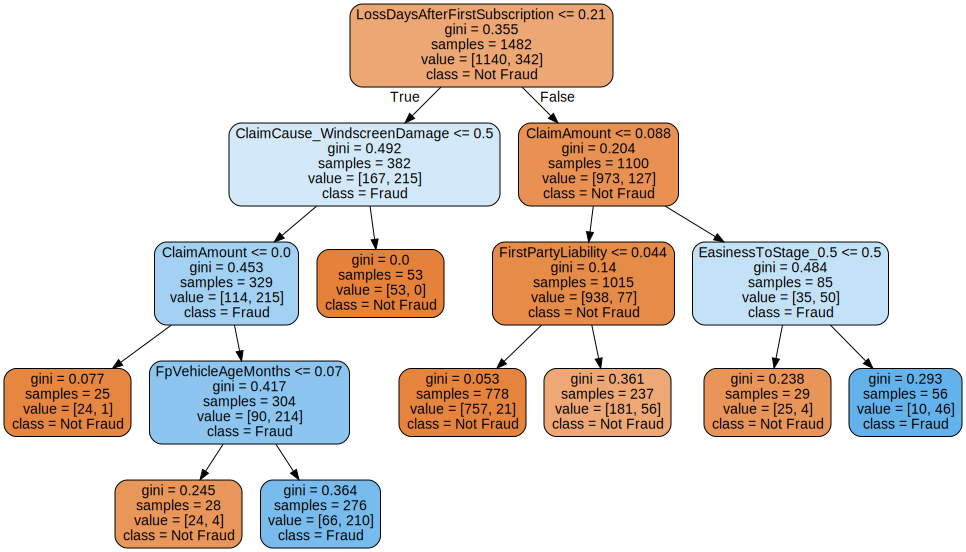

In [253]:
#visualise the tree
import graphviz as gp
from sklearn.tree import export_graphviz
dot_data = export_graphviz(classifier_DT, feature_names = X_synth.columns, filled = True, rounded = True, class_names=['Not Fraud','Fraud'])
graph = gp.Source(dot_data)
graph

In [254]:
#get the model auc score, confusion matric, and accuracy
y_pred_prob = classifier_DT.predict_proba(X_valid)[:,1]
auc_score = metrics.roc_auc_score(y_valid, y_pred_prob)
y_validation_pred = np.where(y_pred_prob < 0.5, 0, 1)
confusionmatrix = metrics.confusion_matrix(y_valid, y_validation_pred)
accuracy_score = metrics.accuracy_score(y_valid,y_validation_pred)

print('Auc score is',auc_score,'\n','confusion matrix is','\n',confusionmatrix,'\n','Accuracy score is', accuracy_score)

Auc score is 0.78459049421533 
 confusion matrix is 
 [[3702  293]
 [  26   15]] 
 Accuracy score is 0.9209613478691774


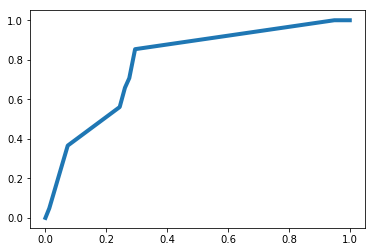

In [255]:
#plot the model
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

#### Model comparison
Compared to former models, the decision tree model's AUC is 0.78 and is performing better than the original model and close to the other two approaches. Although the model has the ability to distinguish fraud and non-fraud clients, the  generated datapoint from oversmapling influenced the classification of the "fraud" class and it is evident from the FP of 293. 

Among all the models, the orginal model cannot predict the fraud cases for the rarity of fraud cases. Both SMOTE model and decision tree model used the same training data but SMOTE model has a better performance, which demonstrating that neural network can sense the pattern difference better than decision tree. The autoencoder model has a different approach to rebuild data, hence it's AUC is relatively better when compared to other models.


#### How the model define a investigated customer
Based on the visualisation of the decision tree model, it presents what variable is considered at each step to classify clients into fraud and non-fraud. In our case, the most important variable is Loss days after the first subscription. Based on the time length that the customer lost their first subscription, then the model considered claims causes' type, claim amount to classify clients, then first party liability, easiness to stage, and vehicle ages to decide the probability of fraud. 